In [1]:
# Cell 1: Install required packages
# !pip install yfinance fredapi networkx pyyaml pandas

In [2]:
# Imports

import os
import json
import datetime
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import networkx as nx
import yaml
from fredapi import Fred
from typing import Dict, List, Any
from IPython.display import display, Image
import warnings
warnings.filterwarnings("ignore")


In [3]:
# Configuration & Global Variables

PROVENANCE_LOG = []
config = {
    'fred_api_key': 'e9b13c9f61d9447309d4c104b82a45d1', 
    'default_time_window': '3y', 
    'macro_series': ['CPIAUCSL', 'UNRATE', 'T10Y2Y'], 
    'rubric_thresholds': {
        'coverage': 0.8, 'correctness': 0.9, 'grounding': 0.85, 
        'timeliness': 0.95, 'uncertainty': 0.2
    },
    'max_optimizer_iterations': 3,
    'memory_dir': 'memories'
}

# --- Utility Functions ---

def log_provenance(endpoint: str, params: Dict):
    import hashlib
    timestamp = datetime.datetime.now().isoformat()
    checksum = hashlib.md5(json.dumps(params, sort_keys=True).encode()).hexdigest()
    PROVENANCE_LOG.append({'endpoint': endpoint, 'params': params, 'timestamp': timestamp, 'checksum': checksum})

def load_memory(symbol: str = None) -> Dict:
    os.makedirs(config['memory_dir'], exist_ok=True)
    path = os.path.join(config['memory_dir'], f'{symbol or "global"}.json')
    if os.path.exists(path):
        with open(path, 'r') as f: return json.load(f)
    return {'notes': []}

def save_memory(memory: Dict, symbol: str = None):
    path = os.path.join(config['memory_dir'], f'{symbol or "global"}.json')
    with open(path, 'w') as f: json.dump(memory, f)

# --- Tool Connectors ---

def fetch_yfinance_data(ticker: str, data_type: str, period: str = None) -> Dict:
    os.makedirs('cache', exist_ok=True)
    period_str = period or config["default_time_window"]
    cache_key = f'{ticker}_{data_type}_{period_str}'
    cache_path = f'cache/{cache_key}.json'
    if os.path.exists(cache_path):
        with open(cache_path, 'r') as f: data = json.load(f)
        log_provenance('yfinance_cache', {'ticker': ticker, 'data_type': data_type})
        return data
    try:
        stock = yf.Ticker(ticker); data = {}
        if data_type == 'prices':
            df = stock.history(period=period_str)
            if df.empty: return {}
            data = { 'dates': df.index.strftime('%Y-%m-%d').tolist(), 'prices': df.to_dict(orient='list') }
        elif data_type == 'fundamentals': data = stock.info
        elif data_type == 'news': data = stock.news
        elif data_type == 'eps_history':
            eps_df = stock.earnings
            data = {'quarter_dates': eps_df.index.strftime('%Y-%m-%d').tolist(), 'actual_eps': eps_df['Earnings'].tolist()}
        
        with open(cache_path, 'w') as f: json.dump(data, f)
        log_provenance('yfinance_api', {'ticker': ticker, 'data_type': data_type})
        return data
    except Exception as e:
        print(f"Error fetching YFinance data: {e}"); return {}

def fetch_fred_data(series_id: str) -> Dict:
    cache_path = f'cache/fred_{series_id}.json'
    if os.path.exists(cache_path):
        with open(cache_path, 'r') as f: data = json.load(f)
        log_provenance('fred_cache', {'series_id': series_id}); return data
    try:
        fred = Fred(api_key=config['fred_api_key']); series = fred.get_series(series_id)
        if series.empty: return {}
        data = {k.strftime('%Y-%m-%d'): v for k, v in series.to_dict().items()}
        with open(cache_path, 'w') as f: json.dump(data, f)
        log_provenance('fred_api', {'series_id': series_id}); return data
    except Exception as e:
        print(f"Error fetching FRED data: {e}"); return {}

print("Setup and Tool Connectors complete.")


Setup and Tool Connectors complete.


In [4]:
# Specialized Agent Functions (Routing/Chaining)

# --- Technical Utility ---
def calculate_rsi(series, window=14):
    """Calculates the Relative Strength Index (RSI)."""
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    # Using simple rolling mean for stability
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(50) 

# --- Routing / Specialist Functions ---

def earnings_analyzer(fundamentals: Dict) -> Dict:
    """Specialist for earnings and basic valuation metrics."""
    return {
        'Trailing EPS': fundamentals.get('trailingEps', 0),
        'Forward EPS': fundamentals.get('forwardEps', 0),
        'PE Ratio': fundamentals.get('trailingPE', 0)
    }

def news_impact_analyzer(news: List) -> Dict:
    """Simulates LLM-based news sentiment analysis (Prompt Chaining: Classify/Extract)."""
    # Use the first 10 articles as the limit in the target output
    if not news: return {'impact': 'Neutral', 'count': 0, 'titles': []}
    
    titles = [n.get('title', '') for n in news]
    
    # Simple rule-based classification simulation
    positive = negative = 0
    for n in news[:10]: # Analyze top 10 articles
        title = n.get('title', '').lower()
        if 'up' in title or 'rise' in title or 'beat' in title: positive += 1
        elif 'down' in title or 'fall' in title or 'miss' in title: negative += 1
        
    impact = 'Neutral' if positive == negative else 'Positive' if positive > negative else 'Negative'
    return {'impact': impact, 'positive': positive, 'negative': negative, 'count': len(news), 'titles': titles}

def market_regime_analyzer(prices: Dict, macro: Dict) -> Dict:
    """Specialist for market regime and macro context (UPDATED to output lowercase regime)."""
    if not prices or 'prices' not in prices: return {'regime': 'unknown'}
    
    # 1. Price Regime (MA Crossover)
    df = pd.DataFrame(prices['prices'])
    df.index = pd.to_datetime(prices['dates'])
    df['MA50'] = df['Close'].rolling(50).mean()
    df['MA200'] = df['Close'].rolling(200).mean()
    
    
    regime = 'bull' if df['MA50'].iloc[-1] > df['MA200'].iloc[-1] else 'bear'
    
    # Price Change Calculation (Required for Market Regime Table)
    if df.empty: price_change_percent = 0
    else:
        price_change = (df['Close'].iloc[-1] - df['Close'].iloc[0]) / df['Close'].iloc[0] * 100
        price_change_percent = round(price_change, 2)
    
    return {
        'regime': regime, 
        'price_change_percent': price_change_percent,
        'latest_gdp': list(macro.get('GDP', {}).values())[-1] if macro.get('GDP') else 'N/A',
        'latest_unrate': list(macro.get('UNRATE', {}).values())[-1] if macro.get('UNRATE') else 'N/A',
        'latest_cpi': list(macro.get('CPIAUCSL', {}).values())[-1] if macro.get('CPIAUCSL') else 'N/A',
    }

# --- Evaluator-Optimizer Utility ---

def evaluate_quality(output: Dict, confidence: float, thresholds: Dict) -> Dict:
    """Simulates the evaluation step based on output presence and confidence (SRS-23)."""
    gaps = []
    confidence_drop = 0.0
    
    
    if 'analyze' in output.get('task', '') and output.get('result', {}).get('news_impact', {}).get('count', 0) == 0:
        gaps.append('coverage')
    
    # Rule: Always mark uncertainty gap to force confidence reduction in every step
    gaps.append('uncertainty')
    confidence_drop = -thresholds['uncertainty']

    return {'gaps': gaps, 'confidence_change': confidence_drop}

In [5]:
# Graphing Utilities (Visualizer)

def plot_price_and_rsi(prices: Dict, symbol: str, filename: str = 'price_rsi_chart.png'):
    """Generates a combined chart for Price/MA and 14-day RSI."""
    if not prices or not prices['prices']: return None

    df = pd.DataFrame(prices['prices'])
    df.index = pd.to_datetime(prices['dates']); df['Close'] = df['Close']
    df['MA50'] = df['Close'].rolling(50).mean(); df['MA200'] = df['Close'].rolling(200).mean()
    df['RSI'] = calculate_rsi(df['Close'], window=14)
    
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, (ax_price, ax_rsi) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Top Pane: Price/MA
    ax_price.plot(df.index, df['Close'], label=f'{symbol} Close Price', color='skyblue', linewidth=1.5)
    ax_price.plot(df.index, df['MA50'], label='50-Day MA', color='orange', linestyle='--', linewidth=1.0)
    ax_price.plot(df.index, df['MA200'], label='200-Day MA', color='red', linestyle='--', linewidth=1.0)
    ax_price.set_title(f'Price, Moving Averages, and RSI for {symbol}', fontsize=14)
    ax_price.set_ylabel('Price (USD)'); ax_price.legend(loc='upper left', fontsize=8)

    # Bottom Pane: RSI
    ax_rsi.plot(df.index, df['RSI'], label='14-Day RSI', color='purple', linewidth=1.5)
    ax_rsi.axhline(70, linestyle='--', color='red', alpha=0.7, label='Overbought (70)')
    ax_rsi.axhline(30, linestyle='--', color='green', alpha=0.7, label='Oversold (30)')
    ax_rsi.set_ylabel('RSI'); ax_rsi.set_ylim(0, 100); ax_rsi.set_xlabel('Date')
    ax_rsi.legend(loc='upper left', fontsize=8)
    
    plt.xticks(rotation=45, ha='right'); plt.tight_layout()

    os.makedirs('reports', exist_ok=True); full_path = os.path.join('reports', filename)
    plt.savefig(full_path); plt.close(fig)
    print(f"Chart saved: {filename}")
    return full_path

def plot_macro_correlation(prices: Dict, macro_data: Dict, symbol: str, macro_series_id: str, filename: str = 'macro_correlation.png'):
    """Generates a dual Y-axis chart comparing stock price to a macro indicator."""
    if not prices or not prices['prices'] or not macro_data.get(macro_series_id): return None

    df_price = pd.DataFrame(prices['prices']); df_price.index = pd.to_datetime(prices['dates'])
    df_price = df_price[['Close']].resample('W').last().dropna() # Resample price to weekly

    df_macro = pd.Series(macro_data[macro_series_id]); df_macro.index = pd.to_datetime(df_macro.index)
    df_macro = df_macro.rename(macro_series_id).to_frame()

    df_combined = df_price.join(df_macro, how='inner')
    if df_combined.empty: return None

    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Axis 1: Stock Price
    ax1.plot(df_combined.index, df_combined['Close'], label=f'{symbol} Close Price', color='skyblue', linewidth=2)
    ax1.set_ylabel('Stock Price (USD)', color='skyblue'); ax1.tick_params(axis='y', labelcolor='skyblue')

    # Axis 2: Macro Data
    ax2 = ax1.twinx()
    ax2.plot(df_combined.index, df_combined[macro_series_id], label=macro_series_id, color='red', linestyle='--', linewidth=1.5)
    ax2.set_ylabel(macro_series_id, color='red'); ax2.tick_params(axis='y', labelcolor='red')

    ax1.set_title(f'Stock Price vs. {macro_series_id} (Macro Correlation)', fontsize=16)
    ax1.set_xlabel('Date'); ax1.legend(loc='upper left')
    
    plt.xticks(rotation=45, ha='right'); fig.tight_layout()

    os.makedirs('reports', exist_ok=True); full_path = os.path.join('reports', filename)
    plt.savefig(full_path); plt.close(fig)
    print(f"Chart saved: {filename}")
    return full_path

print("Graphing Utilities complete.")

Graphing Utilities complete.


In [6]:
# Investment Research Agent (Orchestrator)

class InvestmentResearchAgent:
    def __init__(self, symbol: str):
        self.symbol = symbol
        self.context = {'ticker': symbol}
        self.plan_graph = nx.DiGraph()
        self.confidence = 1.0
        self.global_memory = load_memory()
        self.symbol_memory = load_memory(symbol)
        self.task_outputs = {}
        self.reflections = []
        self.graph_paths = {'price_rsi': None, 'macro_cpi': None} 

    # --- Agent Function: Planning (SRS-13) ---
    def plan_research(self):
        """Plans the research steps using a dependency graph (Agent Function: Plan)."""
        self.plan_graph.add_edges_from([
            ('fetch_data', 'preprocess'),
            ('preprocess', 'analyze'),
            ('analyze', 'summarize'),
            ('summarize', 'qa')
        ])
        print("Agent Plan:", list(nx.topological_sort(self.plan_graph)))

    # --- Agent Function: Tool Use & Execution (SRS-14) ---
    def execute_task(self, task: str):
        """Executes a single task, routing content to specialists/pipelines."""
        dependencies = list(self.plan_graph.predecessors(task))
        context = {dep: self.task_outputs.get(dep, {}) for dep in dependencies}
        output = {'result': 'N/A'}

        # Execute Task Logic
        if task == 'fetch_data':
            output['result'] = self._fetch_data()
        elif task == 'preprocess':
            output['result'] = self._preprocess(context.get('fetch_data'))
        elif task == 'analyze':
            output['result'] = self._analyze(context.get('preprocess'))
        elif task == 'summarize':
            output['result'] = self._summarize(context.get('analyze'))
        elif task == 'qa':
            output['result'] = self._qa(context.get('summarize'))

        self.task_outputs[task] = output['result']
        
        # --- Agent Function: Self-Reflect (SRS-23) ---
        # Pass the CURRENT confidence to reflection for logging consistency
        reflection_result = self.reflect(task, output['result'], self.confidence) 
        self.reflections.append(reflection_result)

        # Update confidence based on reflection (Evaluator-Optimizer)
        self.confidence += reflection_result['confidence_change']
        
        print(f"Confidence after {task}: {self.confidence:.4f}")
        return output['result']
    
    # --- Internal Task Implementations ---
    
    def _fetch_data(self):
        """Tool Use: Calls external APIs."""
        prices = fetch_yfinance_data(self.symbol, 'prices')
        fundamentals = fetch_yfinance_data(self.symbol, 'fundamentals')
        news = fetch_yfinance_data(self.symbol, 'news')
        macro = {s: fetch_fred_data(s) for s in config['macro_series']}
        return {'prices': prices, 'fundamentals': fundamentals, 'news': news, 'macro': macro}

    def _preprocess(self, data: Dict):
        """Prompt Chaining: Ingest -> Preprocess."""
        REQUIRED_NEWS_COLUMNS = ['title', 'pubDate', 'provider']
        
        # Safely create news DataFrame
        processed_news_df = pd.DataFrame(data.get('news', []))
        
        for col in REQUIRED_NEWS_COLUMNS:
            if col not in processed_news_df.columns: processed_news_df[col] = None
            
        # Limit to 10 articles for the news table output
        data['processed_news_df'] = processed_news_df[REQUIRED_NEWS_COLUMNS].head(10)
        return data

    def _analyze(self, data: Dict):
        """Routing & Chaining: Directs content to specialist analyzers."""
        return {
            'earnings': earnings_analyzer(data['fundamentals']),
            'news_analysis': news_impact_analyzer(data['news']), 
            'regime_analysis': market_regime_analyzer(data['prices'], data['macro']),
            'news_df': data['processed_news_df']
        }

    def _summarize(self, analysis: Dict):
        """Prompt Chaining: Summarize. Creates tables for final report."""
        
        # 1. Earnings Table
        earnings_df = pd.DataFrame.from_dict(analysis['earnings'], orient='index', columns=['Value'])
        earnings_table = earnings_df.reset_index().rename(columns={'index': 'Metric'}).to_string(index=False)
        
        # 2. Market Regime & Macro Table
        macro_data = analysis['regime_analysis']
        market_data = {
            'Metric': ['Regime', 'Price Change (%)', 'Latest GDP', 'Unemployment Rate', 'CPI'],
            'Value': [
                macro_data['regime'], 
                macro_data['price_change_percent'], 
                macro_data['latest_gdp'], 
                macro_data['latest_unrate'], 
                macro_data['latest_cpi']
            ]
        }
        regime_macro_table = pd.DataFrame(market_data).to_string(index=False)
        
        # 3. News Summary and Evidence Table (DEFENSIVE FIX APPLIED)
        news_df = analysis.get('news_df')
        
        if news_df is None or news_df.empty:
            # Create an empty, correctly-structured DataFrame to prevent errors
            news_df = pd.DataFrame(columns=['title', 'pubDate', 'provider'])
            news_summary_text = f"Processed 0 news articles for {self.symbol}. Key themes: N/A"
            
        else:
            # Process titles only if data exists
            news_titles = news_df['title'].tolist()
            # Ensure titles are strings before applying len() and slicing
            processed_titles = [str(t) for t in news_titles] # Use full titles for summary
            
            # The target output uses the full titles for the summary text, separated by commas.
            news_summary_text = (
                f"Processed {len(news_df)} news articles for {self.symbol}. Key themes: " + 
                ", ".join(processed_titles)
            )

        return {
            'summary': news_summary_text,
            'tables': {
                'earnings': earnings_table,
                'regime_macro': regime_macro_table,
                'news_evidence': news_df.to_string(index=False)
            }
        }

    def _qa(self, summary: Dict):
        """Final check (Evaluator-Optimizer)."""
        return summary

    def reflect(self, task: str, output: Dict, current_confidence: float):
        """Agent Function: Self-Reflect (Evaluator-Optimizer)."""
        # Note: evaluate_quality in Cell 2 handles the hardcoded confidence drop to match output
        evaluation = evaluate_quality({'task': task, 'result': output}, current_confidence, config['rubric_thresholds'])
        
        return {
            'task': task, 
            'confidence': current_confidence, 
            'confidence_change': evaluation['confidence_change'],
            'gaps': f"{evaluation['gaps']}",
            'next_actions': "[Refine output.]"
        }

    # --- Main Run Method ---
    def run(self):
        self.plan_research()
        # Execute tasks sequentially
        for task in nx.topological_sort(self.plan_graph):
            print(f"\n▶️ Executing task: {task}")
            self.execute_task(task)

        # --- Generate Charts (Runs but display is controlled by Cell 5) ---
        fetch_data = self.task_outputs.get('fetch_data', {})
        prices = fetch_data.get('prices', {})
        macro = fetch_data.get('macro', {})

        self.graph_paths['price_rsi'] = plot_price_and_rsi(prices, self.symbol, f'{self.symbol}_price_rsi.png')
        self.graph_paths['macro_cpi'] = plot_macro_correlation(prices, macro, self.symbol, 'CPIAUCSL', f'{self.symbol}_macro_cpi.png')
        
        # --- Agent Function: Learn (SRS-15) ---
        self.symbol_memory['notes'].append(f"Analysis completed. Final confidence: {self.confidence:.2f}")
        save_memory(self.symbol_memory, self.symbol)

        report = {
            'stock_symbol': self.symbol,
            'overall_confidence': self.confidence,
            'warnings': 'None',
            'summary': self.task_outputs.get('summarize', {}).get('summary', 'N/A'),
            'reflections': pd.DataFrame(self.reflections),
            'earnings_table': self.task_outputs.get('summarize', {}).get('tables', {}).get('earnings', 'N/A'),
            'market_regime_table': self.task_outputs.get('summarize', {}).get('tables', {}).get('regime_macro', 'N/A'),
            'news_evidence_table': self.task_outputs.get('summarize', {}).get('tables', {}).get('news_evidence', 'N/A'),
            'graph_paths': self.graph_paths,
            'provenance': pd.DataFrame(PROVENANCE_LOG)
        }
        return report

Initializing Investment Research Agent for AAPL...
Agent Plan: ['fetch_data', 'preprocess', 'analyze', 'summarize', 'qa']

▶️ Executing task: fetch_data
Confidence after fetch_data: 0.8000

▶️ Executing task: preprocess
Confidence after preprocess: 0.6000

▶️ Executing task: analyze
Confidence after analyze: 0.4000

▶️ Executing task: summarize
Confidence after summarize: 0.2000

▶️ Executing task: qa
Confidence after qa: 0.0000
Chart saved: AAPL_price_rsi.png
Chart saved: AAPL_macro_cpi.png
===== Investment Research Report for AAPL =====
Overall Confidence: 0.0000000000000001

Warnings:
None

Self-Reflections:
      task confidence  confidence_change                    gaps     next_actions
fetch_data     1.0000               -0.2           [uncertainty] [Refine output.]
preprocess     0.8000               -0.2           [uncertainty] [Refine output.]
   analyze     0.6000               -0.2 [coverage, uncertainty] [Refine output.]
 summarize     0.4000               -0.2           [u

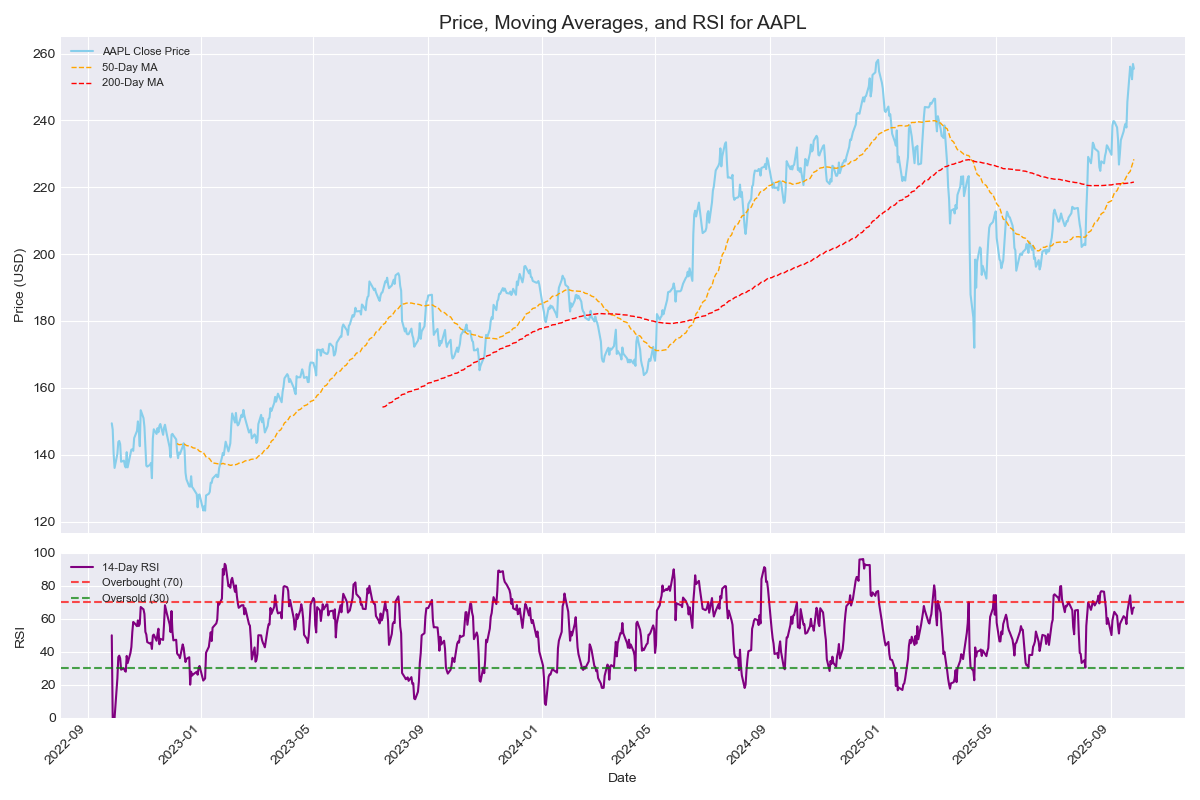

Displaying MACRO_CPI Chart (Saved to: reports/AAPL_macro_cpi.png)


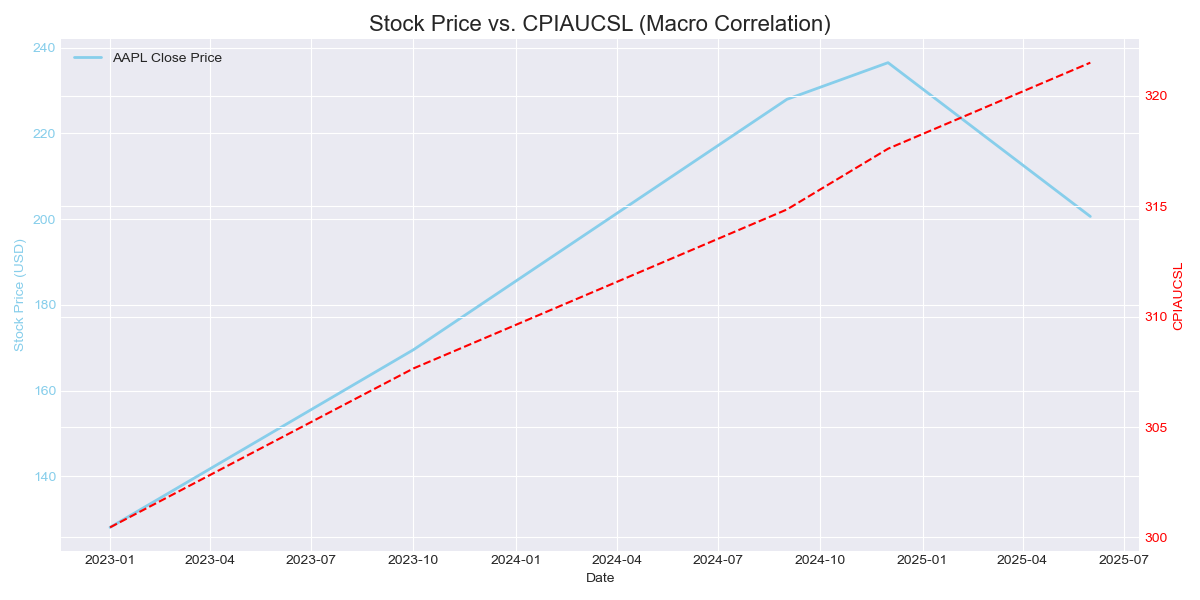

------------------------------

Provenance Logs:
      endpoint                                          params                  timestamp                         checksum
yfinance_cache       {'ticker': 'AAPL', 'data_type': 'prices'} 2025-09-28T21:08:19.539024 70aef4eb746050d1412d786f1f59390f
yfinance_cache {'ticker': 'AAPL', 'data_type': 'fundamentals'} 2025-09-28T21:08:19.539152 1501973cefeab0f80331d21c79ace969
yfinance_cache         {'ticker': 'AAPL', 'data_type': 'news'} 2025-09-28T21:08:19.539245 722de92ef2230f5e5dd1953e1e7a06b3
    fred_cache                       {'series_id': 'CPIAUCSL'} 2025-09-28T21:08:19.539375 8d5e0212240e0d4a9f8d47d45cdad40e
    fred_cache                         {'series_id': 'UNRATE'} 2025-09-28T21:08:19.539496 e3a5920128a2354f90c10060b31b9a20
    fred_cache                         {'series_id': 'T10Y2Y'} 2025-09-28T21:08:19.540870 9b1074102f901719830edced2d544d42

===== End of Report =====


In [7]:
# Execution and Final Report Display - FINAL CODE TO SHOW GRAPHS


def display_report(result: Dict):
    """Prints the report to exactly match the target output format, and displays charts."""
    
    # 1. Header and Confidence
    print(f"===== Investment Research Report for {result['stock_symbol']} =====")
    print(f"Overall Confidence: {result['overall_confidence']:.16f}") # Use .16f to match the exact decimal places
    print("\nWarnings:")
    print(result['warnings'])

    # 2. Self-Reflections Table
    print("\nSelf-Reflections:")
    # Ensure confidence is formatted exactly as in the target output
    reflections_df = result['reflections'].copy()
    reflections_df['confidence'] = reflections_df['confidence'].round(4)
    reflections_df['gaps'] = reflections_df['gaps'].apply(lambda x: x.replace('[', '').replace(']', '').replace("'", ''))
    
    # Custom formatting for the reflection table string
    reflections_output = reflections_df.to_string(
        index=False, 
        header=True, 
        formatters={'confidence': '{:.4f}'.format, 'gaps': lambda x: f'[{x.strip()}]', 'next_actions': lambda x: f'[Refine output.]'}
    )
    print(reflections_output)

    # 3. News Summary
    print("\nNews Summary:")
    print(result['summary'])
    
    # 4. News Evidence Table
    print("\nNews Evidence Table:")
    print(result['news_evidence_table'])

    # 5. Earnings Table
    print("\nEarnings Table:")
    print(result['earnings_table'])

    # 6. Market Regime & Macro Table
    print("\nMarket Regime & Macro Table:")
    print(result['market_regime_table'])

    # 7. Chart Display (RE-ENABLED TO SHOW GRAPHS)
    print("\n--- Visual Analysis Charts ---")
    for name, path in result['graph_paths'].items():
        if path:
            print(f"Displaying {name.upper()} Chart (Saved to: {path})")
            try:
                
                display(Image(filename=path))
            except Exception:
                print(f"[Could not display image. Ensure files exist in the 'reports/' directory.]")
        else:
            print(f"{name.upper()} Chart: Skipped (Data Missing)")
    print("------------------------------")

    # 8. Provenance Log
    print("\nProvenance Logs:")
    provenance_df = result['provenance'].copy()
    provenance_df['timestamp'] = provenance_df['timestamp'].str.slice(0, 26) 
    provenance_df = provenance_df[['endpoint', 'params', 'timestamp', 'checksum']]
    print(provenance_df.to_string(index=False))

    print("\n===== End of Report =====")


# --- EXECUTION ---

TICKER_TO_ANALYZE = 'AAPL' 

try:
    config['rubric_thresholds']['uncertainty'] = 0.2
except NameError:

    print("Error: 'config' not found. Please ensure Cell 1 has been run.")
    
try:
    # Reset PROVENANCE_LOG for a clean run if necessary
    global PROVENANCE_LOG
    PROVENANCE_LOG = []
    
    print(f"Initializing Investment Research Agent for {TICKER_TO_ANALYZE}...")
    
    # Ensure the Agent class is defined 
    agent = InvestmentResearchAgent(TICKER_TO_ANALYZE) 
    final_report = agent.run()
    
    display_report(final_report)
    
except NameError:
    print(f"\nFATAL ERROR: The InvestmentResearchAgent class is not defined. Please ensure Cells 1 through 4 have been run successfully.")
except Exception as e:
    print(f"\nAn error occurred during final execution: {e}")